# Disclaimer

You can find the datasets we used here: https://drive.google.com/drive/folders/1H0fwaJTtXf0Oz-HJX8iYj1gFnAlUToIE?usp=sharing <br>

For the actual cases comparison dataset, you can just make slices from the ```ncr_may72022_casesonly.csv``` 

In [1]:
## Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
get_ipython().run_line_magic('matplotlib', 'inline')
# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
import sklearn 
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
#Comparison Functions

def measure_model_success(realVals, predictedVals):
    rmse = round(mean_squared_error(realVals, predictedVals, squared=False), 2)
    print ("RMSE: {0}".format(rmse))
    mape = round(mean_absolute_percentage_error(realVals, predictedVals) * 100, 2)
    print ("MAPE: {0}".format(mape))
    mae = round(mean_absolute_error(realVals, predictedVals), 2)
    print ("MAE: {0}".format(mae))
    
def measure_model_RMSE(realVals, predictedVals):
    rmse = round(mean_squared_error(realVals, predictedVals, squared=False), 2)
    return rmse 
    print ("RMSE: {0}".format(rmse)) 

In [3]:
import random as rand

def randomSeed(how_many):
    seeds = []
    for i in range(0,how_many):
        n = rand.randint(0,9999)
        seeds.append(int(n))
    return seeds

In [4]:
cd finals_data

C:\Users\keith\Desktop\Programming Notes\Social Computing Class\Thesis\finals_data


# Fixing the Data
https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html#Data

In [5]:
data = pd.read_csv("ncr_may72022_slice.csv")
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

In [6]:
# get all dates for training before Sept 14, 2021
data = data[data['Date'] < "2021-9-14"].reset_index(drop=True)  

In [7]:
data = data.set_index('Date')
data = data.asfreq('D')
data.tail()

,isolation_beds,ward_beds,covid_counts,recovery_counts,death_counts,susceptible_counts,incidence_rate,quarantine_type_int,retail_rec_baseline,grocery_pharma_baseline,parks_baseline,transit_baseline,workplace_baseline,residental_baseline
Date,,,,,,,,,,,,,,
2021-09-09,53,53,6702,230,41,13477489,49.70,3,-46,5,-45,-64,-43,26
2021-09-10,53,53,4394,572,49,13479447,32.59,3,-48,2,-46,-66,-41,28
2021-09-11,55,55,8941,1180,34,13474307,66.31,3,-48,1,-51,-64,-28,23
2021-09-12,55,55,5633,992,35,13477802,41.77,3,-50,3,-49,-65,-21,20
2021-09-13,56,56,5811,966,54,13477631,43.09,3,-44,4,-40,-63,-43,25


In [8]:
# removing the covid_counts for PCA / TSNE
data2 = data.copy()
data2.drop(['covid_counts'], axis=1, inplace=True)
data2

,isolation_beds,ward_beds,recovery_counts,death_counts,susceptible_counts,incidence_rate,quarantine_type_int,retail_rec_baseline,grocery_pharma_baseline,parks_baseline,transit_baseline,workplace_baseline,residental_baseline
Date,,,,,,,,,,,,,
2020-03-17,0,0,7,8,13484409,0.28,4,-76,-39,-69,-81,-71,32
2020-03-18,0,0,8,10,13484433,0.08,4,-81,-49,-75,-87,-76,36
2020-03-19,0,0,3,12,13484434,0.10,4,-83,-54,-76,-88,-78,38
2020-03-20,0,0,4,7,13484439,0.09,4,-84,-56,-78,-90,-79,41
2020-03-21,0,0,8,11,13484388,0.41,4,-84,-56,-77,-89,-72,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-09,53,53,230,41,13477489,49.70,3,-46,5,-45,-64,-43,26
2021-09-10,53,53,572,49,13479447,32.59,3,-48,2,-46,-66,-41,28
2021-09-11,55,55,1180,34,13474307,66.31,3,-48,1,-51,-64,-28,23


In [9]:
#
actual_cases_df = pd.read_csv("sept1427_caseonly.csv")
actual_cases_df['Date'] = pd.to_datetime(actual_cases_df['Date'], format='%m/%d/%Y')
actual_cases_df = actual_cases_df.set_index('Date')
actual_cases_df = actual_cases_df.asfreq('D')

# PCA Original 

In [10]:
scaler = preprocessing.MinMaxScaler()
names = data2.columns
d = scaler.fit_transform(data2)
normed_df = pd.DataFrame(d, columns=names)
normed_df.head()

,isolation_beds,ward_beds,recovery_counts,death_counts,susceptible_counts,incidence_rate,quarantine_type_int,retail_rec_baseline,grocery_pharma_baseline,parks_baseline,transit_baseline,workplace_baseline,residental_baseline
0,0.0,0.0,0.002010,0.089744,0.997039,0.003020,1.0,0.235294,0.366071,0.324324,0.291667,0.215190,0.594595
1,0.0,0.0,0.002513,0.115385,0.999408,0.000000,1.0,0.161765,0.276786,0.243243,0.166667,0.151899,0.702703
2,0.0,0.0,0.000000,0.141026,0.999507,0.000302,1.0,0.132353,0.232143,0.229730,0.145833,0.126582,0.756757
3,0.0,0.0,0.000503,0.076923,1.000000,0.000151,1.0,0.117647,0.214286,0.202703,0.104167,0.113924,0.837838
4,0.0,0.0,0.002513,0.128205,0.994966,0.004983,1.0,0.117647,0.214286,0.216216,0.125000,0.202532,0.594595


In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=3058)
principalComponents = pca.fit_transform(normed_df)

# testing lang based on the 11 dimesnionality stuff
from sklearn.manifold import TSNE
tsne = TSNE(random_state=3058)
X_tsne = tsne.fit_transform(principalComponents)

tsne_df = pd.DataFrame(data = X_tsne, columns = ['tsne_1', 'tsne_2'])
print(tsne_df.shape)
tsne_df.head()

(546, 2)


,tsne_1,tsne_2
0,-30.975407,-4.241792
1,-34.113029,-6.666074
2,-35.256104,-7.616390
3,-37.588451,-8.543857
4,-33.161549,-6.787576


In [12]:
#https://stackoverflow.com/questions/34682828/extracting-specific-selected-columns-to-new-dataframe-as-a-copy
tsne_df.index = data.index
tsne_df["covid_counts"] = data["covid_counts"]
tsne_df

,tsne_1,tsne_2,covid_counts
Date,,,
2020-03-17,-30.975407,-4.241792,38
2020-03-18,-34.113029,-6.666074,11
2020-03-19,-35.256104,-7.616390,13
2020-03-20,-37.588451,-8.543857,12
2020-03-21,-33.161549,-6.787576,55
...,...,...,...
2021-09-09,38.563808,6.951987,6702
2021-09-10,39.455410,6.128143,4394
2021-09-11,37.739971,11.001549,8941


In [13]:
# data for univariate, tsne_df for multivariable 

#data_train = data
data_train = tsne_df
data_train.tail()

,tsne_1,tsne_2,covid_counts
Date,,,
2021-09-09,38.563808,6.951987,6702
2021-09-10,39.455410,6.128143,4394
2021-09-11,37.739971,11.001549,8941
2021-09-12,37.475784,7.866242,5633
2021-09-13,37.882893,9.135976,5811


# RF Trainer and Parameter Tuner (Important)

In [14]:
# Hyperparameter Grid search
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://www.sciencedirect.com/science/article/pii/S0960077921011334
# https://ieeexplore.ieee.org/abstract/document/9343921
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=6935),
                lags      = 14 # This value will be replaced in the grid search
             )

# hyperparameter tuning function, these lists are the possible configurations
param_grid = {'n_estimators': [20, 50, 100, 150],
              'max_depth': [3, 5, 10, 15]}

lags_grid = [7, 14, 30, 60]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['covid_counts'],
                        # comment the exog out if doing univariate but leave it if multivariate
                        exog        = data_train[['tsne_1', 'tsne_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 14,
                        refit       = True,
                        metric      = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(data_train)*0.50),
                        return_best = True,
                        verbose     = False
                    )


Number of models compared: 64


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [10:09<00:00, 152.35s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 15, 'n_estimators': 100}
  Backtesting metric: 0.33134505630352107



In [15]:
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.296705
1,lag_2,0.578013
2,lag_3,0.006360
3,lag_4,0.008748
4,lag_5,0.013524
5,lag_6,0.010937
6,lag_7,0.055243
7,tsne_1,0.017853
8,tsne_2,0.012618


RMSE: 1807.75
MAPE: 41.49
MAE: 1534.66


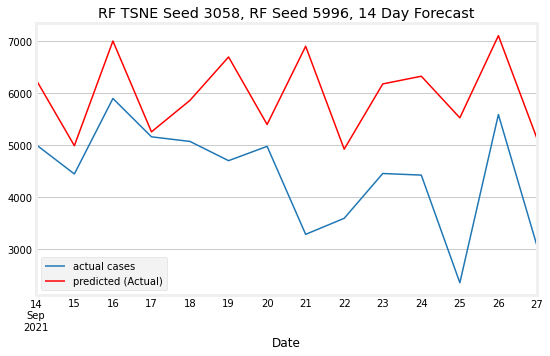

In [16]:
# Predictions
# ==============================================================================
# multivariable
predictions = forecaster.predict(steps=14, exog=data_train[['tsne_1', 'tsne_2']])

#Univariate
#predictions = forecaster.predict(steps=14)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(8, 5))
actual_cases_df['covid_counts'].plot(ax=ax, label='actual cases', color='tab:blue')
predictions.plot(ax=ax, label='predicted (Actual)', color = 'red')
ax.set_facecolor('xkcd:white')
plt.title("RF TSNE Seed 3058, RF Seed 5996, 14 Day Forecast")
ax.legend();
measure_model_success(actual_cases_df['covid_counts'], predictions)

# 10 Fold Cross Validation Function

We used the hyperparameter tuner above to obtain the optimal hyperparameters. Once we have them, we input them into the function below!

In [17]:
seed1 = randomSeed(10)

In [21]:
seed1

[6935, 3337, 7028, 5368, 1853, 3002, 4177, 6008, 8484, 7159]

In [20]:
seed1[0] = 6935

In [22]:
#data_train = data

def generate_models_with_seeds(seed_list, days_to_pred, input_estims, input_depth, input_lags):
    
    seed_numbers = []
    rmse_list = []
    mape_list = []
    mae_list = []
    
    for chosen_seed in seed_list:
        
        # comment this out until the data_train part if univariate
        from sklearn.manifold import TSNE
        tsne = TSNE(random_state=3058)
        X_tsne = tsne.fit_transform(principalComponents)

        tsne_df = pd.DataFrame(data = X_tsne, columns = ['tsne_1', 'tsne_2'])
        tsne_df.index = data.index
        tsne_df["covid_counts"] = data["covid_counts"]
        
        data_train = tsne_df
        #-------------------------------------------------------------------
        
        #forecaster 
        forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=chosen_seed),
                    lags      = 14 # This value will be replaced in the grid search
                 )
        
        #hyperparameter inputs - manually input the optimal parameters obtained from the previous tuner to save compute time
        param_grid = {'n_estimators': [input_estims],
                      'max_depth': [input_depth]}

        lags_grid = [input_lags]

        results_grid = grid_search_forecaster(
                                forecaster  = forecaster,
                                y           = data_train['covid_counts'],
                                # comment the exog out if doing univariate but leave it if multivariate
                                exog        = data_train[['tsne_1', 'tsne_2']],
                                param_grid  = param_grid,
                                lags_grid   = lags_grid,
                                steps       = days_to_pred,
                                refit       = True,
                                metric      = 'mean_squared_error',
                                initial_train_size = int(len(data_train)*0.50),
                                return_best = True,
                                verbose     = False
                            )
        
        #Multivariable
        predictions = forecaster.predict(steps=days_to_pred, exog=data_train[['tsne_1', 'tsne_2']])
        
        #Univariate
#         predictions = forecaster.predict(steps=days_to_pred)
        
        # plotting
        fig, ax=plt.subplots(figsize=(8, 5))
        actual_cases_df['covid_counts'].plot(ax=ax, label='actual cases', color='tab:blue')
        predictions.plot(ax=ax, label='predicted (Actual)', color = 'red')
        ax.set_facecolor('xkcd:white')
        plt.title("RF Risk, TSNE Seed 3058, Seed {0}, {1} Day Forecast".format(chosen_seed, days_to_pred))
        #plt.savefig("results/{0}_RF30_Risk_Seed {1}".format(seed_list.index(chosen_seed), chosen_seed))
        ax.legend();

        #add to the list
        seed_numbers.append(chosen_seed)
        rmse_list.append(measure_model_RMSE(actual_cases_df['covid_counts'], predictions))
        mape_list.append(round(mean_absolute_percentage_error(actual_cases_df['covid_counts'], predictions) * 100, 2))
        mae_list.append(round(mean_absolute_error(actual_cases_df['covid_counts'], predictions), 2))
    
    
    list_joiner = []
    list_joiner.extend([seed_numbers, rmse_list, mape_list, mae_list])
    
    return list_joiner

Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 1234315.302760057

Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.42s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 1106292.1260989334

Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 1021963.710935466

Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.10s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 1017370.8409999587

Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.21s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 1174227.568422837

Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 1041094.0721077016

Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 1137713.8969181918

Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.38s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 1358983.9035915062

Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 1157751.7393903972

Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 1152579.591001376



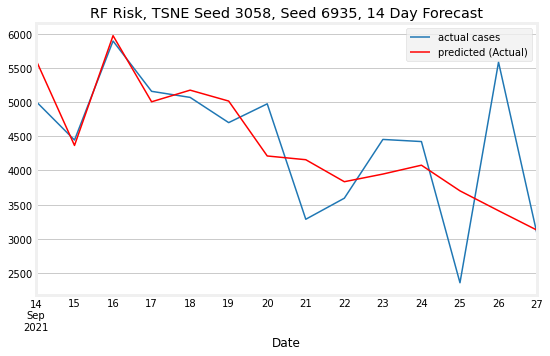

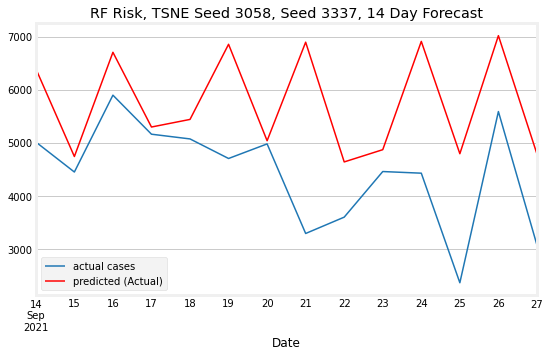

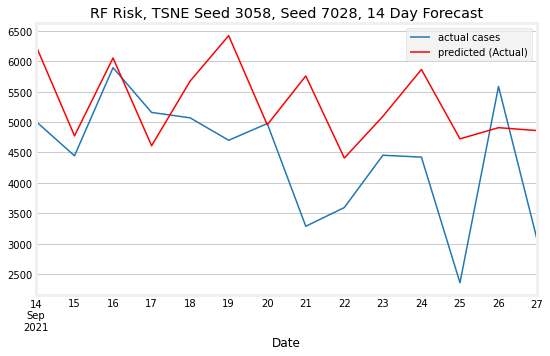

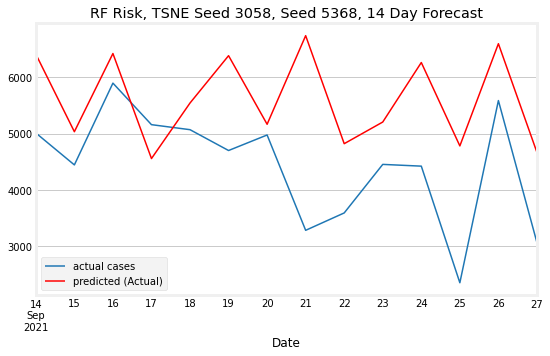

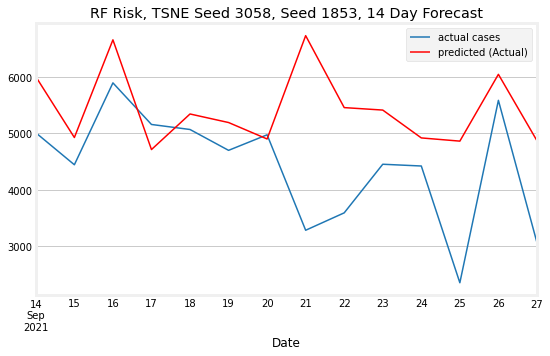

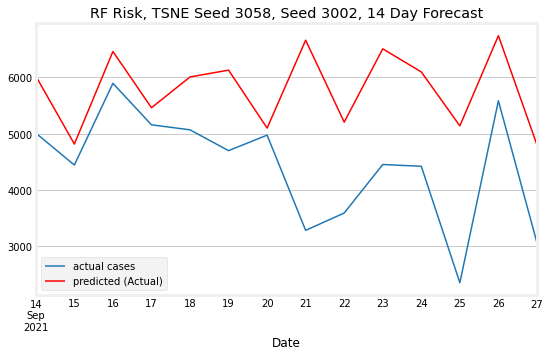

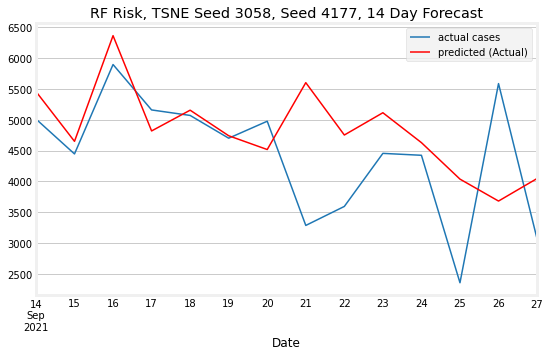

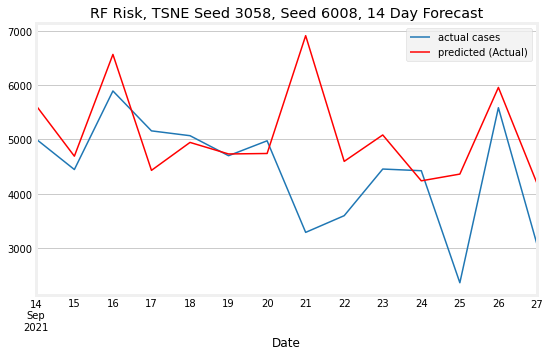

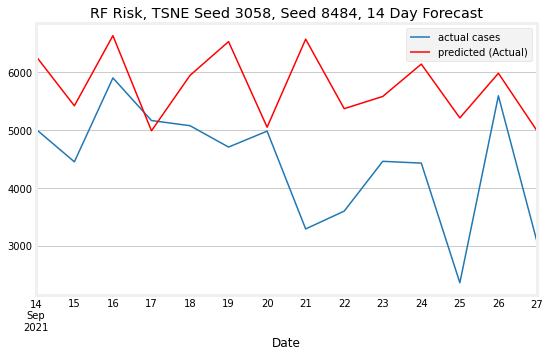

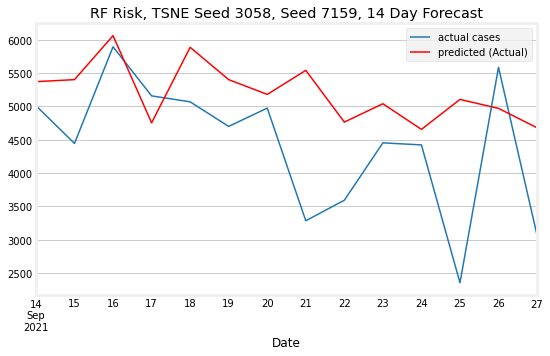

In [27]:
# inputs -> ( seeds, number of days to forecast, n-estimators, depth, lags )
first_attempt = generate_models_with_seeds(seed1, 14, 20, 10, 30)

In [28]:
# save the Seed number and evaluation metrics in a CSV 
one = first_attempt[0]
two = first_attempt[1]
three = first_attempt[2]
four = first_attempt[3]

dictionary_TSNE = {'Seed': one, 'RMSE':two, 'MAPE': three, 'MAE':four}
df_dict = pd.DataFrame(dictionary_TSNE)

#uncomment to save as CSV
#df_dict.to_csv("results/RF_Risk_30Days_2.csv", index = False)

df_dict

,Seed,RMSE,MAPE,MAE
0,6935,794.06,13.76,545.87
1,3337,1664.79,35.27,1309.03
2,7028,1304.67,29.30,1059.02
3,5368,1530.57,34.36,1267.51
4,1853,1428.10,30.87,1075.13
5,3002,1638.39,37.29,1366.18
6,4177,1047.71,21.36,781.31
7,6008,1239.73,24.02,828.99
8,8484,1628.60,37.35,1351.45
9,7159,1189.58,26.73,916.30
